# Variational Autoencoder (VAE)

Useful links: 
* Original paper http://arxiv.org/abs/1312.6114
* Helpful videos explaining the topic 
   * https://www.youtube.com/watch?v=P78QYjWh5sM     
   * http://videolectures.net/deeplearning2015_courville_autoencoder_extension/?q=aaron%20courville

In this homework we will train an autoencoder to model images of faces. For this we take "Labeled Faces in the Wild" dataset [LFW](http://vis-www.cs.umass.edu/lfw/), deep funneled version of it. (frontal view of all faces)


## Prepare the data

In [0]:
import numpy as np
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import matplotlib.pyplot as plt
import torch.distributions as tdist

from torch.autograd import Variable

import io
import PIL
from contextlib import redirect_stdout

%matplotlib inline

**Collab setting**

In [0]:
# if you're running in colab,
# 1. go to Runtime -> Change Runtimy Type -> GPU

In [0]:
# to upload lfw_dataset.py to colab
files.upload()

Saving lfw_dataset.py to lfw_dataset.py


{'lfw_dataset.py': b'import numpy as np\nimport os\nfrom PIL.Image import fromarray\nfrom matplotlib.pyplot import imread\nimport pandas as pd\n\ndef fetch_lfw_dataset(attrs_name = "lfw_attributes.txt",\n                      images_name = "lfw-deepfunneled",\n                      raw_images_name = "lfw",\n                      use_raw=False,\n                      dx=80,dy=80,\n                      dimx=45,dimy=45\n    ): # sad smile\n\n    #download if not exists\n    if (not use_raw) and not os.path.exists(images_name):\n        print("images not found, donwloading...")\n        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")\n        print("extracting...")\n        os.system("tar xvzf tmp.tgz && rm tmp.tgz")\n        print("done")\n        assert os.path.exists(images_name)\n    \n    if use_raw and not os.path.exists(raw_images_name):\n        print("images not found, donwloading...")\n        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw.

In [0]:
# The following line fetches you two datasets: images, usable for autoencoder training, and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind
from lfw_dataset import fetch_lfw_dataset
data, attrs = fetch_lfw_dataset(dimx=36,dimy=36)

In [0]:
data = data / 255
len(data)
np.savez("real.npz", Pictures=data.reshape(data.shape[0], 36, 36, 3))

In [55]:
X_train = data[:10000].reshape((10000, -1))
print(X_train.shape)
X_val = data[10000:].reshape((-1, X_train.shape[1]))
print(X_val.shape)

image_h = data.shape[1]
image_w = data.shape[2]

(10000, 3888)
(3143, 3888)


For simplicity we want all values of the data to lie in the interval $[0,1]$:

In [0]:
X_train = np.float32(X_train)
X_val = np.float32(X_val)
train_loader = data_utils.DataLoader(torch.from_numpy(X_train), 
                                     batch_size=128, shuffle=True)

val_loader = data_utils.DataLoader(torch.from_numpy(X_val), 
                                   batch_size=32, shuffle=False)

In [57]:
print(X_train)

[[0.3647059  0.26666668 0.14901961 ... 0.2509804  0.25882354 0.24705882]
 [0.32941177 0.18039216 0.16862746 ... 0.4392157  0.42352942 0.49019608]
 [0.45490196 0.3764706  0.34901962 ... 0.29411766 0.27450982 0.2627451 ]
 ...
 [0.24313726 0.18039216 0.11764706 ... 0.60784316 0.47058824 0.39607844]
 [0.9098039  0.59607846 0.40392157 ... 0.02352941 0.00392157 0.01960784]
 [0.8784314  0.7647059  0.73333335 ... 0.5882353  0.47058824 0.43137255]]


In [0]:
def plot_gallery(images, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w, 3)), cmap=plt.cm.gray, 
                          vmin=-1, vmax=1, interpolation='nearest')
        plt.xticks(())
        plt.yticks(())

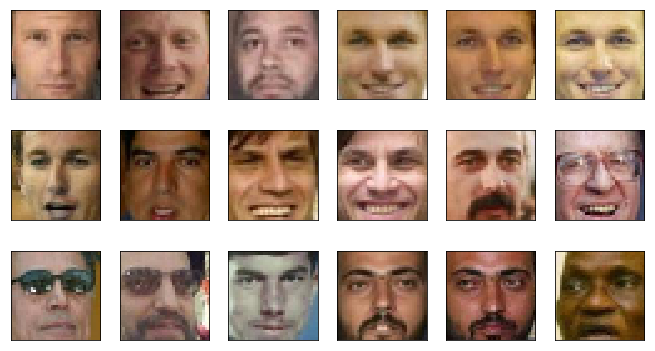

In [59]:
plot_gallery(X_train, image_h, image_w)

# Autoencoder

Why to use all this complicated formulaes and regularizations, what is the need for variational inference? To analyze the difference, let's first train just an autoencoder on the data:

<img src="Autoencoder_structure.png" alt="Autoencoder">

In [0]:
dimZ = 100 # Considering face reconstruction task, which size of representation seems reasonable?

# Define the decoder and encoder as networks with one hidden fc-layer
# (that means you will have 2 fc layers in each net)
# Use ReLU for hidden layers' activations
# GlorotUniform initialization for W
# Zero initialization for biases
# It's also convenient to put sigmoid activation on output layer to get nice normalized pics

class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        #TODO
        # weights initialization:
        # https://stackoverflow.com/questions/49433936/how-to-initialize-weights-in-pytorch
        def init_weights(l):
            if isinstance(l, nn.Linear):
                torch.nn.init.xavier_uniform_(l.weight)
                l.bias.data.fill_(0.)
            
        self.encoder = nn.Sequential(
            nn.Linear(3 * 36 * 36, 1024),
            nn.ReLU(True),
            nn.Linear(1024, dimZ),
            #nn.ELU(inplace=True) # Non-linearity here degrades the network's performance. Why?
        )
        self.encoder.apply(init_weights)
        
        self.decoder = nn.Sequential(
            nn.Linear(dimZ, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 3 * 36 * 36),
            nn.Sigmoid()
        )
        self.decoder.apply(init_weights)
        
    def forward(self, x):
        
        #TODO
        
        latent_code = self.encoder(x)
        reconstruction = self.decoder(latent_code)
        
        return reconstruction, latent_code

In [0]:
# Train your autoencoder
# Visualize progress in reconstruction and loss decay
def train_ae(model, dataloader, 
             criterion, optimizer,
             num_epoch=32, images=None):
    
    if images is not None and len(images) > 1:
        assert isinstance(images, torch.Tensor), \
        "images must be of tensor type"
        assert len(images), \
        "Pass no more than 3 images"
        assert images.size() == (len(images), 3 * 36 * 36), \
        "Pass images of the flattaned size 3 * 36 * 36"
    
    since = time.time()
    denom = num_epoch / 20
    count = 0
    if images is not None:
        if len(images) > 1:
            print("Images selected for visualization")
            plot_gallery(images, 36, 36, n_row=1, n_col=3)
            plt.show()
        else:
            image_progress = []
    loss_by_epoch = []
    print("Training has begun...")
    print("=====================================")
    for epoch in range(num_epoch):
        mean_loss = 0.
        for k, batch in enumerate(dataloader):
            optimizer.zero_grad()
            batch = batch.to(device)
            recs,_ = model(batch)
            
            loss = criterion(recs, batch)
            loss.backward()
            optimizer.step()
            
            mean_loss += loss.item()
        mean_loss /= (k + 1)
        loss_by_epoch.append(mean_loss)
        print("#%i, Train loss: %.7f"%(epoch + 1, mean_loss))
        if images is not None:
            if int(epoch / denom) >= count:
                count += 1
                recs = model(images.to(device))[0].detach().cpu().numpy()
                if len(images) == 1:
                    image_progress.append(recs.squeeze())
                else:
                    plot_gallery(recs, 36, 36, n_row=1, n_col=len(images))
                    plt.show()
                
    if images is not None and len(images) == 1:
        return image_progress
        
    tspan = time.time() - since
    print("===============================================")
    print('Training complete in %.f m %.f s' % (tspan // 60, tspan % 60))
              
    plt.plot(loss_by_epoch)
    plt.grid()
    plt.ylabel("loss")
    plt.xlabel("epochs")
    plt.title("Training Loss history")
    

Images selected for visualization


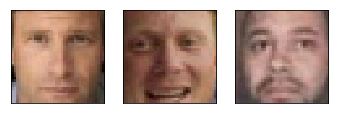

Training has begun...
#1, Train loss: 0.0220602


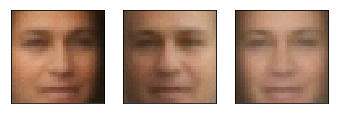

#2, Train loss: 0.0149730
#3, Train loss: 0.0124646


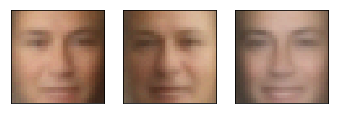

#4, Train loss: 0.0106530
#5, Train loss: 0.0092324


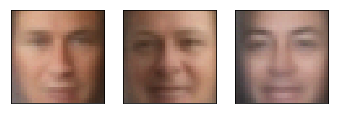

#6, Train loss: 0.0081219


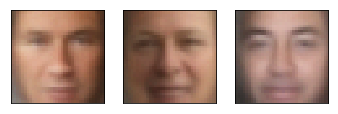

#7, Train loss: 0.0072484
#8, Train loss: 0.0067020


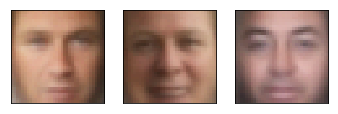

#9, Train loss: 0.0062311


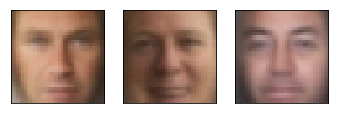

#10, Train loss: 0.0059926
#11, Train loss: 0.0057347


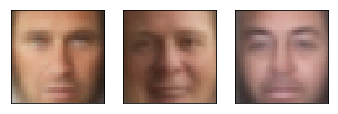

#12, Train loss: 0.0055264
#13, Train loss: 0.0053366


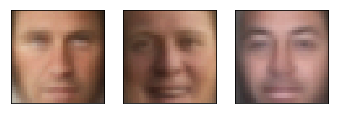

#14, Train loss: 0.0051714


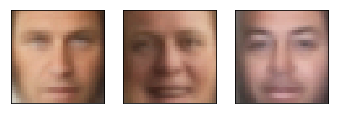

#15, Train loss: 0.0050465
#16, Train loss: 0.0049870


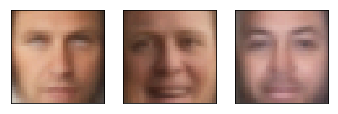

#17, Train loss: 0.0048177


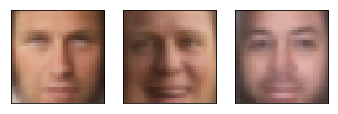

#18, Train loss: 0.0047508
#19, Train loss: 0.0046232


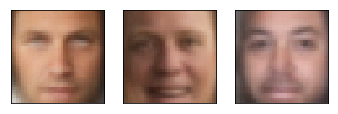

#20, Train loss: 0.0045226
#21, Train loss: 0.0044464


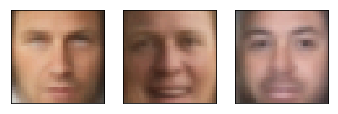

#22, Train loss: 0.0043342


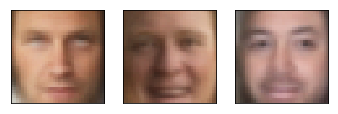

#23, Train loss: 0.0044329
#24, Train loss: 0.0042399


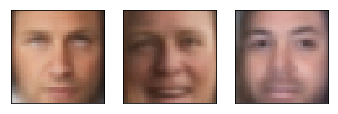

#25, Train loss: 0.0041732


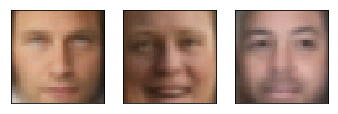

#26, Train loss: 0.0042347
#27, Train loss: 0.0040727


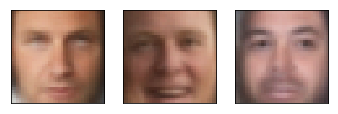

#28, Train loss: 0.0040786
#29, Train loss: 0.0039946


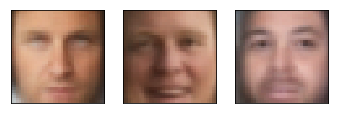

#30, Train loss: 0.0040395


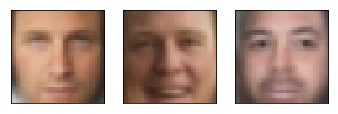

#31, Train loss: 0.0038860
#32, Train loss: 0.0071539


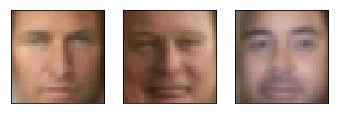

Training complete in 0 m 17 s


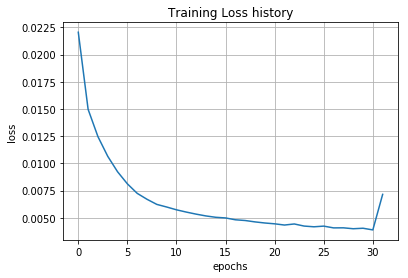

In [62]:
# Create MSE loss function
criterion = torch.nn.MSELoss()

# Define to calculate on GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

autoencoder = Autoencoder().to(device)

# Use Adam optimizer
optimizer = optim.Adam(autoencoder.parameters())

img = torch.from_numpy(X_train[:3])
train_ae(autoencoder, train_loader, criterion, optimizer, images=img)

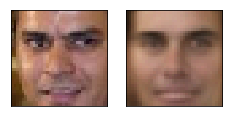

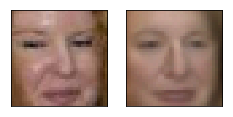

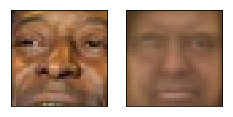

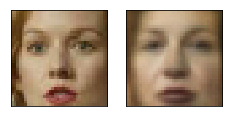

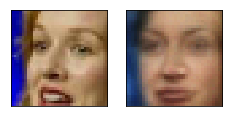

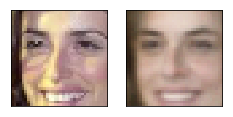

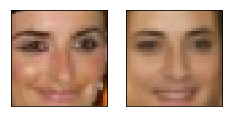

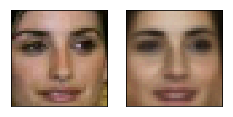

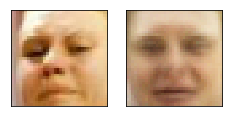

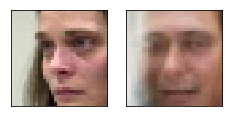

In [63]:
# Examine the reconstructions
loader = data_utils.DataLoader(torch.from_numpy(X_val), 
                                   batch_size=1, shuffle=False)
autoencoder.eval()
for j, batch in enumerate(loader):
    input = Variable(batch.to(device))
    pred, _ = autoencoder(input)
    plot_gallery([batch.numpy(), pred.data.cpu().numpy()], 
                       image_h, image_w, n_row=1, n_col=2)
    if (j >= 9):
        break

Reconstruction is not bad, right? 

# Sampling

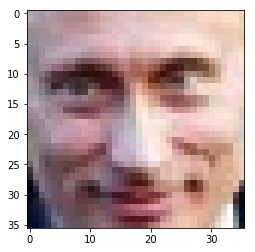

In [64]:
for i, Putin in enumerate(loader):
    if i == 2754:
        break
plt.imshow(Putin.numpy().reshape((image_w, image_w, 3)));

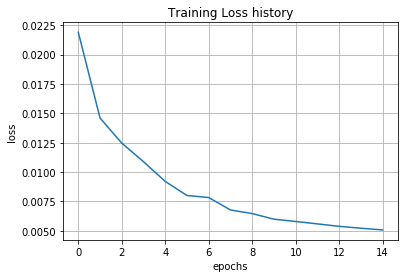

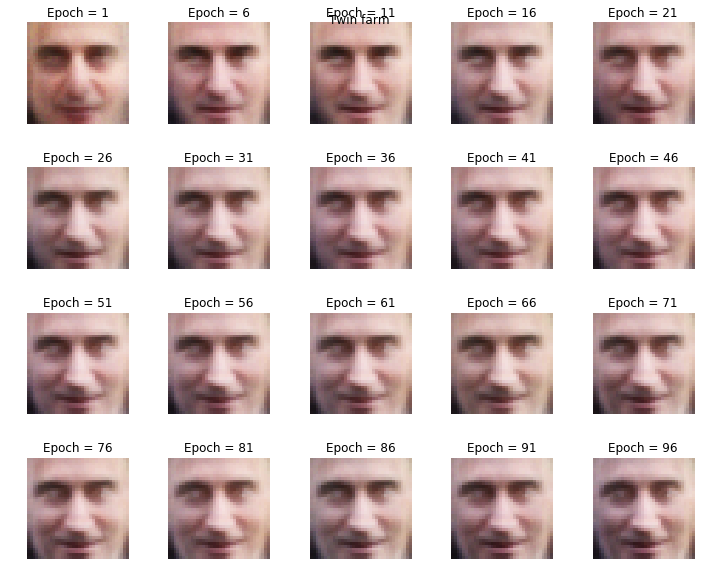

In [65]:
val_loader = data_utils.DataLoader(torch.from_numpy(X_val), 
                                   batch_size=100, shuffle=False)
Putin = Putin.unsqueeze(0)
autoencoder = Autoencoder().to(device)

optimizer = optim.Adam(autoencoder.parameters())

# suppressing stdout  https://codingdose.info/2018/03/22/supress-print-output-in-python/
trap = io.StringIO()
with redirect_stdout(trap):
    train_ae(autoencoder, train_loader, 
                criterion, optimizer, num_epoch=15)
    image_progress = train_ae(autoencoder, val_loader, criterion, 
                                 optimizer, num_epoch=20, images=Putin)
plt.figure(figsize=(10, 12))
plt.suptitle('Twin farm')
for i in range(len(image_progress)):
    plt.subplots_adjust(bottom=0.0, left=.1, right=.9, top=.50, hspace=.15)
    plt.subplot(6, 5, 5 * (i // 5) + i % 5 + 1)
    plt.imshow(image_progress[i].clip(0,1).reshape(image_w, image_h, 3))
    plt.title('Epoch = {}'.format(i * 5 + 1))
    plt.axis('off')
plt.tight_layout()

Let's now sample several latent vectors and perform inference from $z$, reconstruct an image given some random $z$ representations.

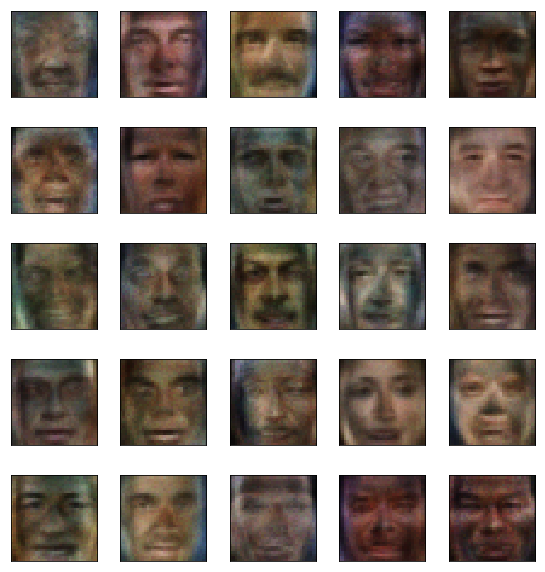

In [66]:
z = (np.random.randn(25, dimZ)*0.5).astype('float32')
output = autoencoder.decoder(Variable(torch.from_numpy(z)).to(device)).clamp(0, 1)
plot_gallery(output.data.cpu().numpy(), image_h, image_w, n_row=5, n_col=5)

So, if we sample $z$ from normal, whould we eventually generate all possible faces? What do you think?

# Variational Autoencoder

Bayesian approach in deep learning considers everything in terms of distributions. Now our encoder generates not just a vector $z$ but posterior ditribution $q(z|x)$. In our case distribution $q$ is Gaussian distibution $N(\mu, \sigma)$ with parameters $\mu$, $\sigma$. Technically, the first difference is that you need to split bottleneck layer in two. One dense layer will generate vector $\mu$, and another will generate vector $\sigma$. Reparametrization trick should be implemented using the **gaussian_sampler** layer, that generates random vetor $\epsilon$ and returns $\mu+\sigma\epsilon \sim N(\mu, \sigma)$ .

Since our decoder is also a function that generates distribution, we need to do the same splitting for output layer. When testing the model we will look only on mean values, so one of the output will be actual autoencoder output.

In this homework we only ask for implementation of the simplest version of VAE - one $z$ sample per input. You can consider to sample several outputs from one input and average them.

In [0]:
# to compare with conventional AE, keep these hyperparameters
# or change them for the values that you used before
dimZ = 100

# define the network
# you can start from https://github.com/pytorch/examples/blob/master/vae/main.py
# or Theano-based examples here https://github.com/Lasagne/Recipes/blob/master/examples/variational_autoencoder/variational_autoencoder.py
# and here https://github.com/y0ast/Variational-Autoencoder/blob/master/VAE.py
# but remember that this is not your ground truth since the data is not MNIST

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        
        
        # TODO
        # based on https://github.com/wanglouis49/pytorch-autoencoders/blob/master/conv_vae.py
        #          https://github.com/pytorch/examples/blob/master/vae/main.py
        
        dimI  = 3 * 36 * 36
        tmpD = 640
        # encoder
        self.stack1 = nn.Sequential(
            nn.Linear(dimI, tmpD, bias=False),
            nn.BatchNorm1d(tmpD),
            nn.ReLU(True),
            nn.Dropout(),
        )
        self.stack2 = nn.Sequential(
            nn.Linear(dimZ, tmpD, bias=False),
            nn.BatchNorm1d(tmpD),
            nn.ReLU(True),
            nn.Dropout()
        )
        
        self.fc1 = nn.Linear(3 * 36 * 36, tmpD)
        
        # latent space (!= ls) 
        self.fc21 = nn.Linear(tmpD, dimZ)        
        self.fc22 = nn.Linear(tmpD, dimZ)
        
        # decoder
        self.fc3  = nn.Linear(dimZ, tmpD)
        self.fc41 = nn.Linear(tmpD, 3 * 36 * 36)
        self.fc42 = nn.Linear(tmpD, 3 * 36 * 36)

    
    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            std = logsigma.exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu
        
    def encode(self, x):
        h1 = self.stack1(x)
        
        return self.fc21(h1), self.fc22(h1)
        
    def decode(self, z):
        h3 = self.stack2(z)
        rec_mu = torch.sigmoid(self.fc41(h3))
        rec_ls = torch.sigmoid(self.fc42(h3))
        
        return rec_mu, rec_ls
        
    def forward(self, x):
        
        # TODO
        # return reconstruction_mu (rec_mu), 
        #        reconstruction_logsigma (rec_ls), 
        #        latent_mu (lat_mu), 
        #        latent_logsigma (lat_ls)
        
        lat_mu, lat_ls = self.encode(x)
        z = self.gaussian_sampler(lat_mu, lat_ls)
        rec_mu, rec_ls = self.decode(z)
        
        return rec_mu, rec_ls, lat_mu, lat_ls
        

And the last, but not least! Place in the code where the most of the formulaes goes to - optimization objective. The objective for VAE has it's own name - variational lowerbound. And as for any lowerbound our intention is to maximize it. Here it is (for one sample $z$ per input $x$):

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p_{\theta}(z)) + \log p_{\theta}(x|z)$$

Your next task is to implement two functions that compute KL-divergence and the second term - log-likelihood of an output. Here is some necessary math for your convenience:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$
$$\log p_{\theta}(x|z) = \sum_{i=1}^{dimX}\log p_{\theta}(x_i|z)=\sum_{i=1}^{dimX} \log \Big( \frac{1}{\sigma_i\sqrt{2\pi}}e^{-\frac{(\mu_I-x)^2}{2\sigma_i^2}} \Big)=...$$

Don't forget in the code that you are using $\log\sigma$ as variable. Explain, why not $\sigma$?

In [0]:
# because of numerical stability. sigma -> 0 => |log(sigma)| -> inf 
# why not logvar? if it is more convinient (in my biased opinion)
def KL_divergence(mu, logsigma):
    res = -.5 * torch.sum(+ 1 
                          + 2 * logsigma 
                          - mu ** 2 
                          - (2 * logsigma).exp(),
                          dim=1)
    return res

# .5 * log(2 * pi) ~= .4
def log_likelihood(x, mu, logsigma):
    res = torch.sum(-.4  - logsigma 
                    -.5 * (x - mu) ** 2 
                    / (2 * logsigma).exp(),
                    dim=1)
    return res

def loss_vae(x, mu_gen, logsigma_gen, mu_z, logsigma_z):
    return KL_divergence(mu_z, logsigma_z) \
           - log_likelihood(x, mu_gen, logsigma_gen)

And train the model:

In [0]:
# train your autoencoder
# visualize progress in reconstruction and loss decay

# OK, there was no point in writing a function, since things to apply it to
# are different. Nevertheless...

def train_vae(model, 
                criterion, optimizer,
                num_epoch=32, images=None):
    
    if images is not None:
        assert isinstance(images, torch.Tensor), \
        "images must be of tensor type"
        assert len(images), \
        "Pass no more than 3 images"
        assert images.size() == (len(images), 3 * 36 * 36), \
        "Pass images of the flattaned size 3 * 36 * 36"
    
    since = time.time()
    denom = num_epoch / 20
    count = 0
    if images is not None:
        print("Images selected for visualization")
        plot_gallery(images, 36, 36, n_row=1, n_col=3)
        plt.show()

    train_loss, val_loss = [], []
    print("Training has begun...")
    print("===============================================")
    for epoch in range(num_epoch):
        print('EPOCH %i' % (epoch + 1))
        mean_loss = 0.
        for batch in train_loader:
            optimizer.zero_grad()
            batch = batch.to(device)
            rec_mu, rec_ls, lat_mu, lat_ls = model(batch)
            loss = criterion(batch, rec_mu, rec_ls, 
                             lat_mu, lat_ls).mean()
            loss.backward()
            optimizer.step()
            
            mean_loss += loss.item() * batch.size(0)
        mean_loss /= len(train_loader.dataset)
        train_loss.append(mean_loss)
        print("\tTrain loss: %.7f" % mean_loss)
        
    
        with torch.no_grad():
            mean_loss = 0.
            for batch in val_loader:
                batch = batch.to(device)
                rec_mu, rec_ls, lat_mu, lat_ls = model(batch)
                loss = criterion(batch, rec_mu, rec_ls, 
                                 lat_mu, lat_ls).mean()

                mean_loss += loss.item() * batch.size(0)
            mean_loss /= len(val_loader.dataset)
            val_loss.append(mean_loss)
            print("\tVal loss: %.7f" % mean_loss)
            
        if images is not None:
            if int(epoch / denom) >= count:
                count += 1
                recs = model(images.to(device))[0].detach().cpu().numpy()
                plot_gallery(recs, 36, 36, n_row=1, n_col=len(images))
                plt.show()
        
    tspan = time.time() - since
    print("===============================================")
    print('Training complete in %.f m %.f s' % (tspan // 60, tspan % 60))
              
    plt.plot(train_loss)
    plt.plot(val_loss)
    plt.grid()
    plt.ylabel("loss")
    plt.xlabel("epochs")
    plt.title("Training Loss history")

Images selected for visualization


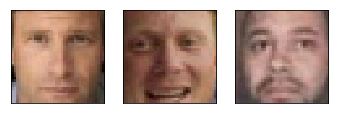

Training has begun...
EPOCH 1
	Train loss: 660016201.7906895
	Val loss: 1629.6189374


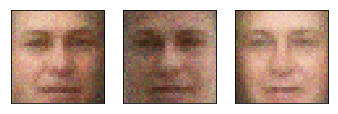

EPOCH 2
	Train loss: 1618.4877775
	Val loss: 1604.8600951
EPOCH 3
	Train loss: 1599.5733754
	Val loss: 1596.5580908
EPOCH 4
	Train loss: 1593.2124301
	Val loss: 1591.9846341


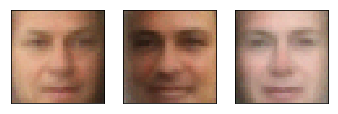

EPOCH 5
	Train loss: 1589.1843129
	Val loss: 1589.0474578
EPOCH 6
	Train loss: 1586.8898934
	Val loss: 1586.6765665


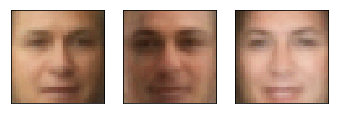

EPOCH 7
	Train loss: 1585.1120508
	Val loss: 1585.3343309
EPOCH 8
	Train loss: 1583.7898855
	Val loss: 1584.5065999
EPOCH 9
	Train loss: 1582.9300840
	Val loss: 1583.5858959


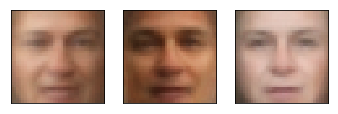

EPOCH 10
	Train loss: 1582.0880680
	Val loss: 1582.5121528
EPOCH 11
	Train loss: 1581.3937299
	Val loss: 1582.3411149


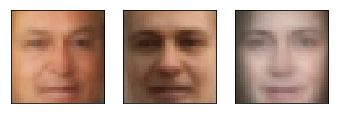

EPOCH 12
	Train loss: 1580.8878461
	Val loss: 1581.5265543
EPOCH 13
	Train loss: 1580.6670609
	Val loss: 1582.1771844
EPOCH 14
	Train loss: 1580.3961865
	Val loss: 1581.7696736


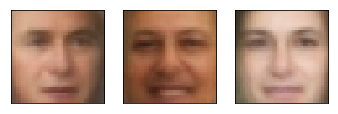

EPOCH 15
	Train loss: 1580.0700730
	Val loss: 1580.9115359
EPOCH 16
	Train loss: 1579.7430299
	Val loss: 1580.3238678


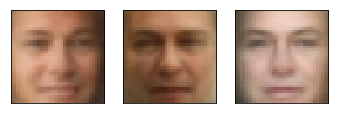

EPOCH 17
	Train loss: 1579.5819611
	Val loss: 1580.7418700
EPOCH 18
	Train loss: 1579.4921195
	Val loss: 1580.5493442
EPOCH 19
	Train loss: 1579.1456795
	Val loss: 1580.1752850


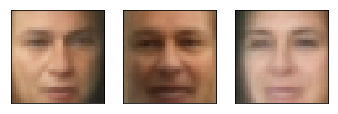

EPOCH 20
	Train loss: 1578.9781547
	Val loss: 1579.7472469
EPOCH 21
	Train loss: 1578.8927801
	Val loss: 1580.0413781


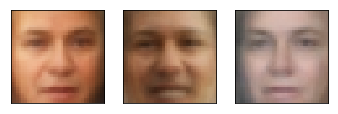

EPOCH 22
	Train loss: 1578.8192076
	Val loss: 1579.6737539
EPOCH 23
	Train loss: 1578.5283875
	Val loss: 1579.4710229
EPOCH 24
	Train loss: 1578.4569426
	Val loss: 1579.7098667


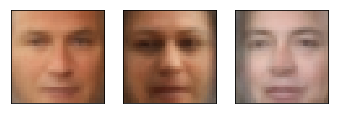

EPOCH 25
	Train loss: 1578.4447637
	Val loss: 1579.8403117
EPOCH 26
	Train loss: 1578.1425031
	Val loss: 1579.2032615


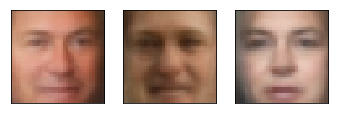

EPOCH 27
	Train loss: 1578.0268488
	Val loss: 1579.0621306
EPOCH 28
	Train loss: 1577.9849150
	Val loss: 1578.8618661
EPOCH 29
	Train loss: 1577.8282736
	Val loss: 1578.9259814


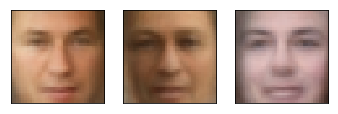

EPOCH 30
	Train loss: 1577.7790744
	Val loss: 1578.9621444
EPOCH 31
	Train loss: 1577.6955801
	Val loss: 1578.9843230


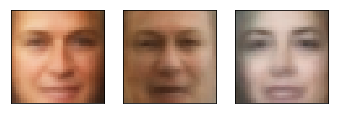

EPOCH 32
	Train loss: 1577.5365301
	Val loss: 1578.7140473
EPOCH 33
	Train loss: 1577.3469305
	Val loss: 1578.3793168
EPOCH 34
	Train loss: 1577.3529055
	Val loss: 1578.7219519


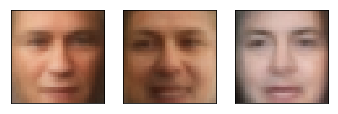

EPOCH 35
	Train loss: 1577.1640918
	Val loss: 1578.4664191
EPOCH 36
	Train loss: 1577.1650457
	Val loss: 1578.4899842


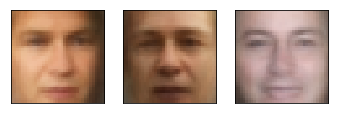

EPOCH 37
	Train loss: 1576.9677502
	Val loss: 1578.1157503
EPOCH 38
	Train loss: 1577.0118246
	Val loss: 1578.5007875
EPOCH 39
	Train loss: 1576.8421385
	Val loss: 1579.0307060


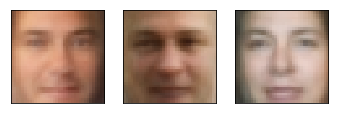

EPOCH 40
	Train loss: 1576.7493150
	Val loss: 1577.8894362
EPOCH 41
	Train loss: 1576.6137672
	Val loss: 1577.9910062


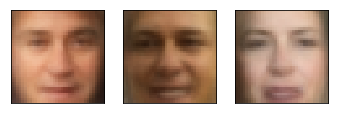

EPOCH 42
	Train loss: 1576.6782699
	Val loss: 1577.7277381
EPOCH 43
	Train loss: 1576.6146051
	Val loss: 1578.2252605
EPOCH 44
	Train loss: 1576.5619045
	Val loss: 1577.3868303


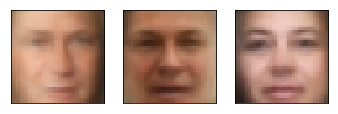

EPOCH 45
	Train loss: 1576.4369227
	Val loss: 1577.5789014
EPOCH 46
	Train loss: 1576.2904020
	Val loss: 1577.3989080


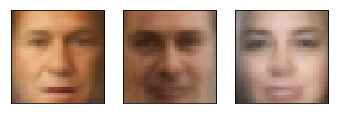

EPOCH 47
	Train loss: 1576.2670813
	Val loss: 1577.8773283
EPOCH 48
	Train loss: 1576.3925512
	Val loss: 1577.4362663
EPOCH 49
	Train loss: 1576.2111475
	Val loss: 1577.4296577


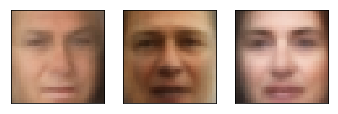

EPOCH 50
	Train loss: 1576.1052668
	Val loss: 1577.1111657
Training complete in 0 m 34 s


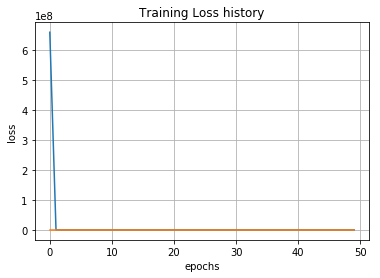

In [70]:
# Create MSE loss function
criterion = loss_vae

# Define to calculate on GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

vae = VAE().to(device)
# Use Adam optimizer
optimizer = optim.Adam(vae.parameters())

img = torch.from_numpy(X_train[:3])
train_vae(vae, criterion, 
          optimizer, num_epoch=50, images=img)

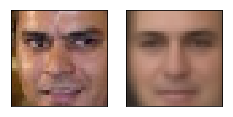

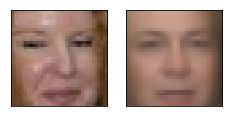

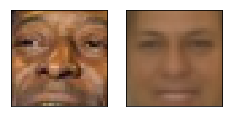

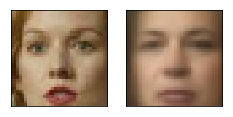

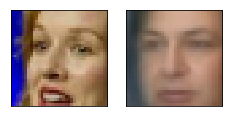

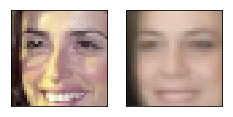

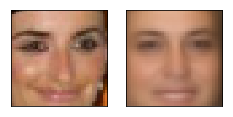

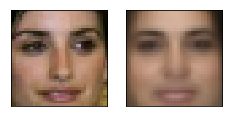

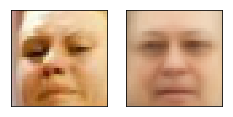

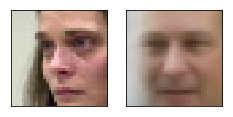

In [71]:
loader = data_utils.DataLoader(torch.from_numpy(X_val), 
                                   batch_size=1, shuffle=False)
vae.eval()
for j, batch in enumerate(loader):
    input = Variable(batch.to(device))
    rec_mu= vae(input)[0]
    plot_gallery([batch.numpy(), rec_mu.data.cpu().numpy()], 
                          image_h, image_w, n_row=1, n_col=2)
    if (j >= 9):
        break

And finally sample from VAE.

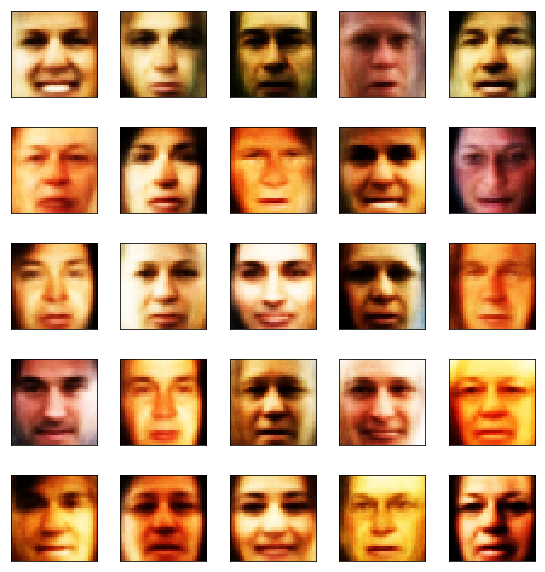

In [72]:
# TODO
# Sample some images from the learned distribution
# 1) Sample z ~ N(0,1)
# 2) Sample from N(decoder_mu(z), decoder_sigma(z))

z = torch.randn(25, dimZ)
output,_ = vae.decode(z.to(device))

output.clamp_(0, 1)
plot_gallery(output.data.cpu().numpy(), image_h, image_w, 5, 5)


Even if in practice you do not see the much difference between AE and VAE, or VAE is even worse, the little bayesian inside you should be jumping for joy right now. 

In VAE you can truly sample from image distribution $p(x)$, while in AE there is no easy and correct way to do it. 

## If you are going to do part 4 (presicion-recall score): 

In [0]:
# using your model, generate face set with len = len(data)
#answ = <generated dataset>
num_images = 1000
batch_size = 100

all_images = []

for batch_i in range((num_images - 1) // batch_size + 1):
    z = torch.randn(batch_size, dimZ)
    output = vae.decode(z.to(device))[0].view(batch_size, 3, 36, 36)
    images = output.data.cpu().numpy().transpose([0, 2, 3, 1])
    if np.var(images)!=0:
        images = images.clip(np.min(data), np.max(data))

    all_images.append(images)
    
all_images = np.concatenate(all_images, axis=0)[:num_images]

## Save it to npz

In [0]:
np.savez("vae_1000.npz", Pictures=all_images)

In [0]:
from google.colab import files
files.download('real.npz')
files.download('vae_1000.npz')

# Congrats! and Bonus

If you managed to tune your autoencoders to converge and learn something about the world, now it's time to make fun out of it. As you may have noticed, there are face attributes in dataset. We're interesting in "Smiling" column, but feel free to try others as well! Here is the first task:

1) Extract the "Smiling" attribute and create a two sets of images: 10 smiling faces and 10 non-smiling ones.

2) Compute latent representations for each image in "smiling" set and average those latent vectors. Do the same for "non-smiling" set. You have found **"vector representation"** of the "smile" and "no smile" attribute.

3) Compute the difference: "smile" vector minus "non-smile" vector.

3) Now check if **"feature arithmetics"** works. Sample a face without smile, encode it and add the diff from p. 3. Check if it works with both AE and VAE. 

<img src="linear.png" alt="linear">

In [95]:
attrs.columns

Index(['Male', 'Asian', 'White', 'Black', 'Baby', 'Child', 'Youth',
       'Middle Aged', 'Senior', 'Black Hair', 'Blond Hair', 'Brown Hair',
       'Bald', 'No Eyewear', 'Eyeglasses', 'Sunglasses', 'Mustache', 'Smiling',
       'Frowning', 'Chubby', 'Blurry', 'Harsh Lighting', 'Flash',
       'Soft Lighting', 'Outdoor', 'Curly Hair', 'Wavy Hair', 'Straight Hair',
       'Receding Hairline', 'Bangs', 'Sideburns', 'Fully Visible Forehead',
       'Partially Visible Forehead', 'Obstructed Forehead', 'Bushy Eyebrows',
       'Arched Eyebrows', 'Narrow Eyes', 'Eyes Open', 'Big Nose',
       'Pointy Nose', 'Big Lips', 'Mouth Closed', 'Mouth Slightly Open',
       'Mouth Wide Open', 'Teeth Not Visible', 'No Beard', 'Goatee',
       'Round Jaw', 'Double Chin', 'Wearing Hat', 'Oval Face', 'Square Face',
       'Round Face', 'Color Photo', 'Posed Photo', 'Attractive Man',
       'Attractive Woman', 'Indian', 'Gray Hair', 'Bags Under Eyes',
       'Heavy Makeup', 'Rosy Cheeks', 'Shiny Skin', 'Pa

In [0]:
men = attrs[attrs['Male'] > 0]
women = attrs[attrs['Male'] < 0]

smiling_women = women[women['Smiling'] > .5]['Smiling']
gloomy_women  = women[women['Smiling'] < -.5]['Smiling']

smiling_men = men[men['Smiling'] > .5]['Smiling']
gloomy_men  = men[men['Smiling'] < -.5]['Smiling']

ids_10_smiling_people = np.r_[np.random.choice(smiling_men.index, 5),
                              np.random.choice(smiling_women.index, 5)]

ids_10_gloomy_people = np.r_[np.random.choice(gloomy_men.index, 5),
                             np.random.choice(gloomy_women.index, 5)]

sad_people = attrs[attrs['Smiling'] < 0]
ids_10_test_subjects = np.random.choice(sad_people.index, 10)

In [0]:
def plot_data10(ids10):
    for i in range(0, 10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(data[ids10][i])

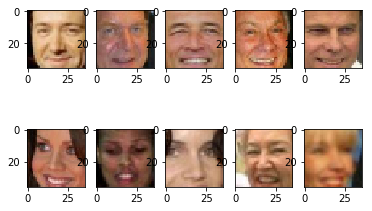

In [107]:
plot_data10(ids_10_smiling_people)

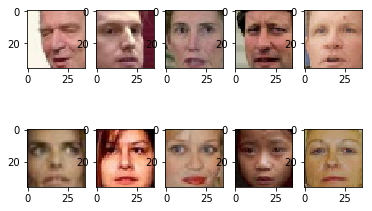

In [108]:
plot_data10(ids_10_gloomy_people)

In [0]:
batch_joy = (data[ids_10_smiling_people]).reshape(10, -1)
batch_sad = (data[ids_10_gloomy_people]).reshape(10, -1)

test_subjects = (data[ids_10_test_subjects]).reshape(10, -1)

batch_joy = torch.from_numpy(np.float32(batch_joy)).to(device)
batch_sad = torch.from_numpy(np.float32(batch_sad)).to(device)

test_batch = torch.from_numpy(np.float32(test_subjects)).to(device)

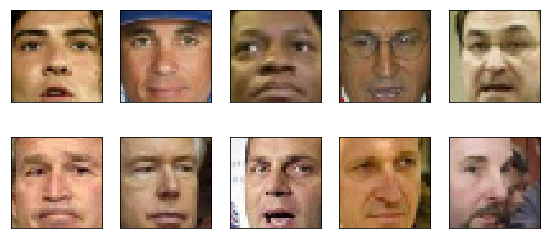

In [110]:
plot_gallery(test_subjects, image_h, image_w, 2, 5)

In [0]:
smiling  = vae.encode(batch_joy)[0].mean(dim=0)
serious = vae.encode(batch_sad)[0].mean(dim=0)

testing_serious = vae.encode(test_batch)[0]
imposed_smile = testing_serious + smiling - serious

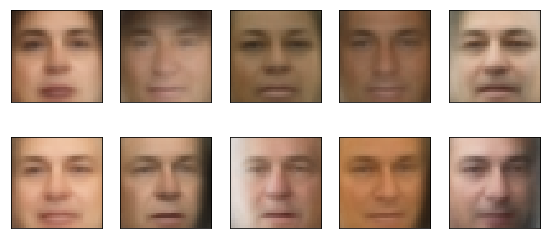

In [112]:
output = vae.decode(testing_serious)[0]
output.clamp_(0, 1)
plot_gallery(output.data.cpu().numpy(), image_h, image_w, 2, 5)

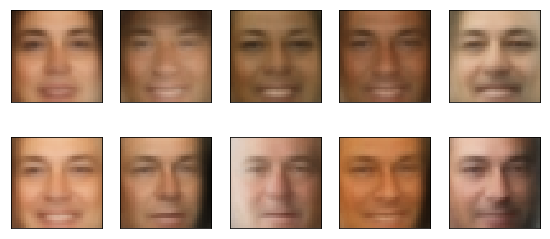

In [113]:
output = vae.decode(imposed_smile)[0]
output.clamp(0, 1)
plot_gallery(output.data.cpu().numpy(), image_h, image_w, 2, 5)

In [0]:
# Why is it so bad?